<a href="https://colab.research.google.com/github/AlienX77-cmd/Computational-Finance/blob/main/LSTM_for_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

###**Import Thai Oil Public Company Limited**

In [176]:
# Thai Oil Public Company Limited
# Ticker = TOP.BK

df_TOP = yf.download("TOP.BK", start="2005-01-01", end="2023-09-05")
df_TOP.fillna(method='bfill', inplace=True) #ถ้ามี null value ใน feature ใดก็ตาม ให้ทำการ replace ด้วย bfill method (เอาค่าก่อนหน้ามาแทนที่)
df_TOP.tail(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-29,53.00,53.00,52.50,52.75,52.75,9823400
2023-08-30,53.25,53.50,52.75,53.00,53.00,9948200
2023-08-31,52.75,52.75,50.75,51.50,51.50,35377000
2023-09-01,52.00,52.00,51.25,51.50,51.50,11230200
2023-09-04,51.00,51.50,48.25,48.75,48.75,67823200


In [177]:
df_TOP.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-04,51.00,51.5,49.50,51.00,21.600279,33823800
2005-01-05,51.00,51.5,49.75,50.00,21.176737,26217900
2005-01-06,49.75,50.5,49.50,49.75,21.070862,16487600
2005-01-07,50.50,50.5,49.75,50.00,21.176737,11556700
2005-01-10,50.00,50.5,49.50,49.75,21.070862,18773400


In [178]:
df_TOP.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-29,53.00,53.00,52.50,52.75,52.75,9823400
2023-08-30,53.25,53.50,52.75,53.00,53.00,9948200
2023-08-31,52.75,52.75,50.75,51.50,51.50,35377000
2023-09-01,52.00,52.00,51.25,51.50,51.50,11230200
2023-09-04,51.00,51.50,48.25,48.75,48.75,67823200


In [179]:
df_TOP.shape

(4573, 6)

##**1. Data Exploration**

In [180]:
def calculate_returns(df):
    df['Return'] = df["Adj Close"].pct_change(1)
    df['Log_Return'] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    df['Cumulative_Return'] = np.cumsum(df['Return'])

In [181]:
calculate_returns(df_TOP)

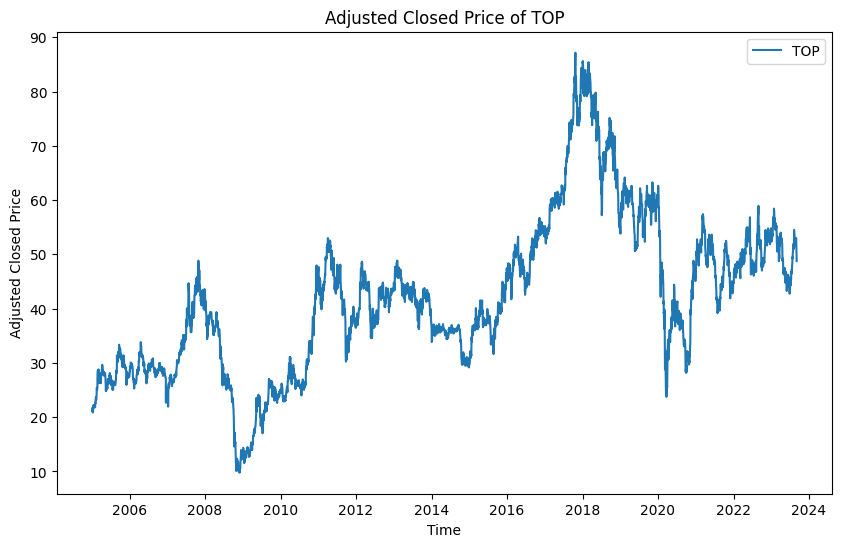

In [182]:
# Plotting Price of TOP
plt.figure(figsize=(10, 6))
plt.plot(df_TOP['Adj Close'], label='TOP')
plt.xlabel('Time')
plt.ylabel('Adjusted Closed Price')
plt.legend()
plt.title('Adjusted Closed Price of TOP')
plt.show()

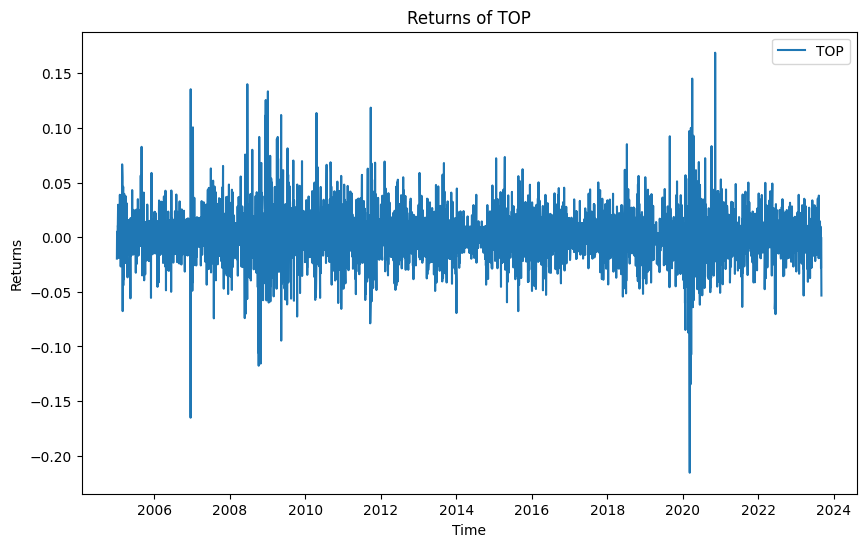

In [183]:
# Plotting Returns of TOP
plt.figure(figsize=(10, 6))
plt.plot(df_TOP['Return'], label='TOP')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.title('Returns of TOP')
plt.show()

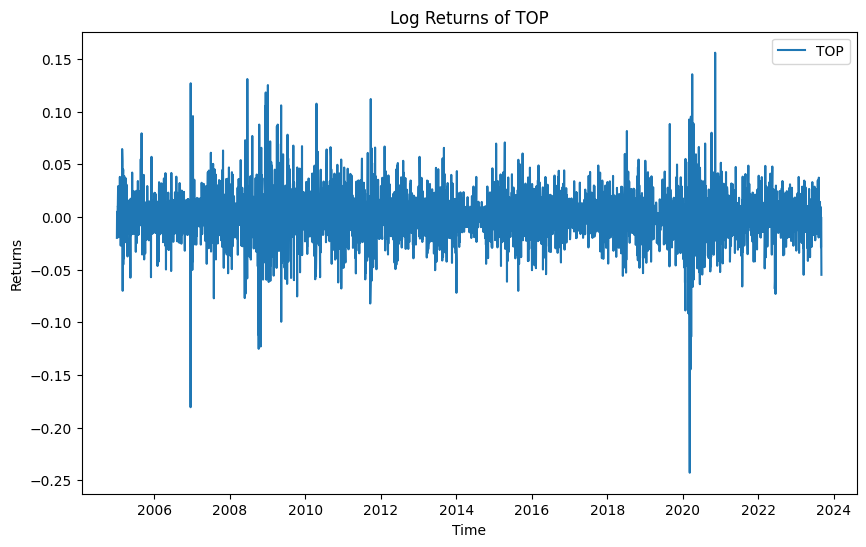

In [184]:
# Plotting Log Returns of TOP
plt.figure(figsize=(10, 6))
plt.plot(df_TOP['Log_Return'], label='TOP')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.title('Log Returns of TOP')
plt.show()

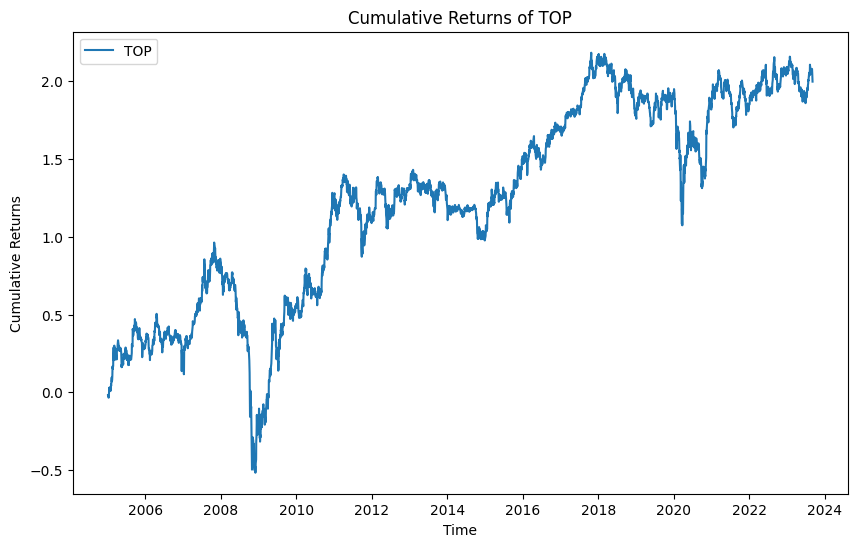

In [185]:
# Plotting Cummulative Returns of TOP
plt.figure(figsize=(10, 6))
plt.plot(df_TOP['Cumulative_Return'], label='TOP')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns of TOP')
plt.show()

In [186]:
df_TOP.head(5)

,Open,High,Low,Close,Adj Close,Volume,Return,Log_Return,Cumulative_Return
Date,,,,,,,,,
2005-01-04,51.00,51.5,49.50,51.00,21.600279,33823800,NaN,NaN,NaN
2005-01-05,51.00,51.5,49.75,50.00,21.176737,26217900,-0.019608,-0.019803,-0.019608
2005-01-06,49.75,50.5,49.50,49.75,21.070862,16487600,-0.005000,-0.005012,-0.024608
2005-01-07,50.50,50.5,49.75,50.00,21.176737,11556700,0.005025,0.005012,-0.019583
2005-01-10,50.00,50.5,49.50,49.75,21.070862,18773400,-0.005000,-0.005012,-0.024583


##**2. Train/Test splitting and Feature Scaling**

In [187]:
df_TOP.iloc[:, 4:5] # Adj Close

,Adj Close
Date,
2005-01-04,21.600279
2005-01-05,21.176737
2005-01-06,21.070862
2005-01-07,21.176737
2005-01-10,21.070862
...,...
2023-08-29,52.750000
2023-08-30,53.000000
2023-08-31,51.500000


In [188]:
df_TOP.iloc[:, 0:1]

,Open
Date,
2005-01-04,51.00
2005-01-05,51.00
2005-01-06,49.75
2005-01-07,50.50
2005-01-10,50.00
...,...
2023-08-29,53.00
2023-08-30,53.25
2023-08-31,52.75


In [189]:
4573 * 0.8
# training data = 80% of data
# testing data  = 20% of data

3658.4

In [190]:
# keras only takes numpy array
training_set = df_TOP.iloc[:3658, 0:1].values
testing_set = df_TOP.iloc[3659:, 0:1].values

In [191]:
training_set.shape

(3658, 1)

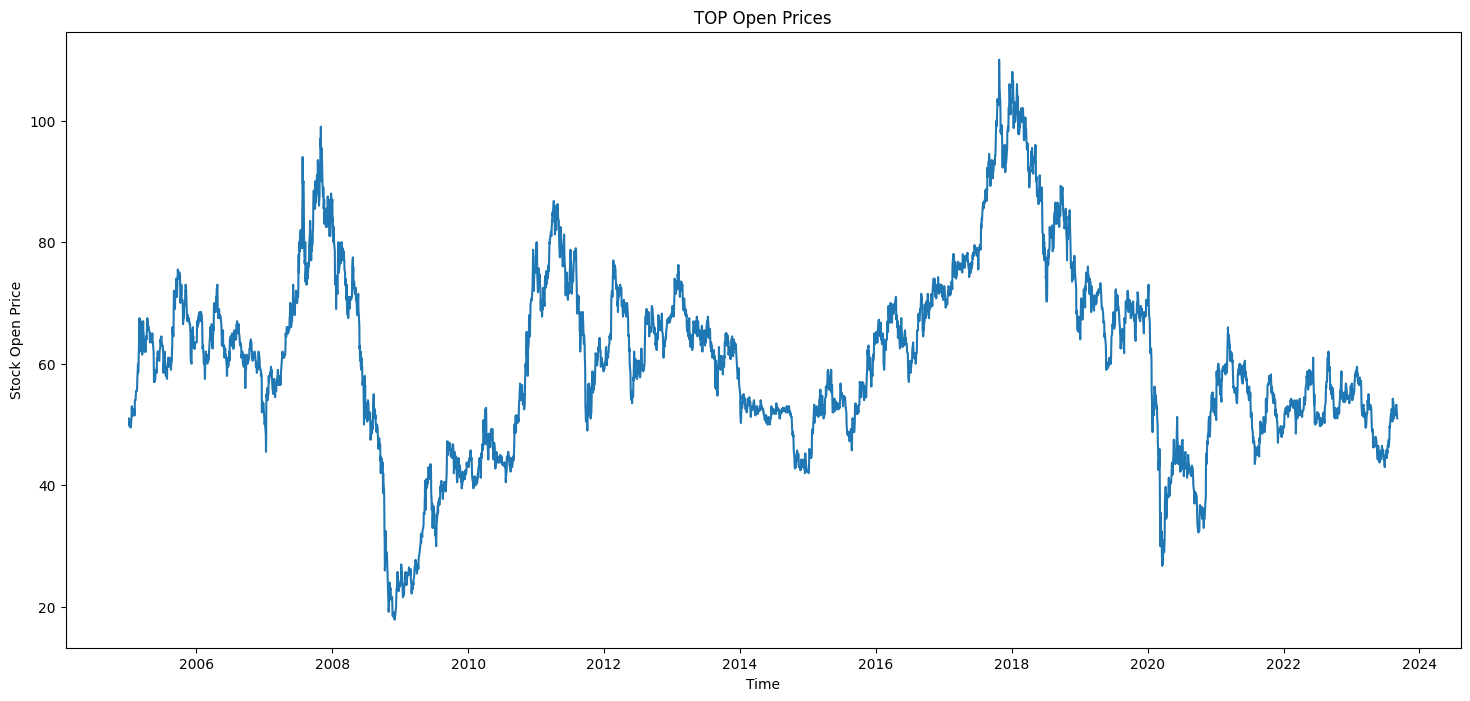

In [192]:
plt.figure(figsize=(18, 8))
plt.plot(df_TOP['Open'])
plt.title("TOP Open Prices")
plt.xlabel("Time")
plt.ylabel("Stock Open Price")
plt.show()

In [193]:
# 2.1 Feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [194]:
## 60 timesteps and 1 output

'''
- taking the reference of past 60 days of data to predict the future stock price.
- It is observed that taking 60 days of past data gives us best results.
- In this data set 60 days of data means 3 months of data.
- Every month as 20 days of Stock price.
- X train will have data of 60 days prior to our date and y train will have data of one day after our date
'''

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [195]:
X_train.shape

(3598, 60)

In [196]:
y_train.shape

(3598,)

In [197]:
# 2.2 Data reshaping
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [198]:
'''
Number of stock prices - 3598
Number of time steps - 60
Number of Indicator - 1
'''

X_train.shape

(3598, 60, 1)

## **3. Create & Fit Model**

In [199]:
regressor = Sequential()
# add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

## add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

## add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

## add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

## add output layer
regressor.add(Dense(units = 1))

In [200]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [201]:
# Model fit
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 35)

Epoch 1/100
113/113 [==============================] - 15s 84ms/step - loss: 0.0120
Epoch 2/100
113/113 [==============================] - 10s 85ms/step - loss: 0.0042
Epoch 3/100
113/113 [==============================] - 10s 85ms/step - loss: 0.0038
Epoch 4/100
113/113 [==============================] - 10s 85ms/step - loss: 0.0034
Epoch 5/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0030
Epoch 6/100
113/113 [==============================] - 10s 84ms/step - loss: 0.0029
Epoch 7/100
113/113 [==============================] - 10s 85ms/step - loss: 0.0026
Epoch 8/100
113/113 [==============================] - 10s 84ms/step - loss: 0.0028
Epoch 9/100
113/113 [==============================] - 10s 85ms/step - loss: 0.0024
Epoch 10/100
113/113 [==============================] - 9s 81ms/step - loss: 0.0022
Epoch 11/100
113/113 [==============================] - 9s 83ms/step - loss: 0.0021
Epoch 12/100
113/113 [==============================] - 10s 85ms/step - loss:

##**4 Model evaluation**


In [210]:
testing_set = df_TOP.iloc[3659:, 0:1].values
testing_set.shape

(914, 1)

In [218]:
testing_set_scaled = sc.transform(testing_set)

In [232]:
len(testing_set_scaled)

914

In [233]:
# make numpy array as 3D , adding num of indicator
X_test = np.reshape(testing_set_scaled, newshape = (testing_set_scaled.shape[0], testing_set_scaled.shape[1], 1))

###**Model prediction**

In [234]:
predicted_stock_price = regressor.predict(X_test)

29/29 [==============================] - 0s 2ms/step


In [235]:
# inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

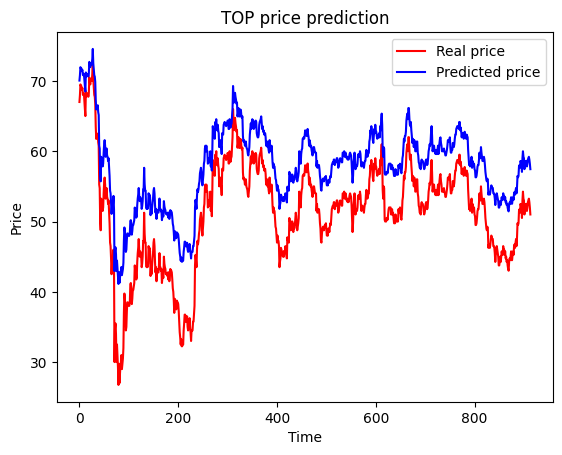

In [236]:
# Result visualization
## visualize the prediction and real price
plt.plot(testing_set, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('TOP price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()